#**RAG with Langgraph**
* Use FAISS as a retriever node

* Update the LangGraph to use retrieved context from FAISS

* Let the LLM generate a final answer

####**Steps:**
1. Load and Read hrdataset
2. Split the text into chunks
3. Create Embeddings & Vectorstore using FAISS
4. Instantiate a Retriever
5. Define Nodes
6. Build a Graph
7. Display a Graph
8. Invoke a Graph



###**Install Dependencies**

In [18]:
!pip install langchain langchain-openai faiss-cpu langgraph langchain-community langchain-text-splitters langchain-huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 43.9 MB/s eta 0:00:00


###**Downloads the `hrdataset.zip` file from the CloudYuga GitHub repo**

In [39]:
!wget https://github.com/cloudyuga/mastering-genai-w-python/raw/refs/heads/main/hrdataset.zip

--2025-05-27 19:13:23--  https://github.com/cloudyuga/mastering-genai-w-python/raw/refs/heads/main/hrdataset.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cloudyuga/mastering-genai-w-python/refs/heads/main/hrdataset.zip [following]
--2025-05-27 19:13:24--  https://raw.githubusercontent.com/cloudyuga/mastering-genai-w-python/refs/heads/main/hrdataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9530 (9.3K) [application/zip]
Saving to: ‘hrdataset.zip.1’

hrdataset.zip.1     100%[===================>]   9.31K  --.-KB/s    in 0s      

2025-05-27 19:13:24 (66.4 MB/s) - ‘hrdataset.zip.1’

###**Unzip `hrdataset.zip` file**
- It will automatically create **`hrdataset`** folder in our current working directory (/content/ in Google Colab)

In [4]:
!unzip hrdataset.zip

Archive:  hrdataset.zip
   creating: hrdataset/
   creating: hrdataset/policies/
  inflating: hrdataset/policies/leave_policies.md  
  inflating: hrdataset/policies/training_and_development.md  
  inflating: hrdataset/policies/employee_benefits.md  
  inflating: hrdataset/policies/holiday_calendar.md  
  inflating: hrdataset/policies/events_calendar.md  
   creating: hrdataset/surveys/
  inflating: hrdataset/surveys/Employee_Culture_Survey_Responses.csv  
   creating: hrdataset/employees/
  inflating: hrdataset/employees/108_Rajesh_Kulkarni.md  
  inflating: hrdataset/employees/106_Neha_Malhotra.md  
  inflating: hrdataset/employees/103_Anjali_Das.md  
  inflating: hrdataset/employees/105_Sunita_Patil.md  
  inflating: hrdataset/employees/101_Priya_Sharma.md  
  inflating: hrdataset/employees/102_Rohit_Mehra.md  
  inflating: hrdataset/employees/104_Karan_Kapoor.md  
  inflating: hrdataset/employees/109_Meera_Iyer.md  
  inflating: hrdataset/employees/110_Aditya_Jain.md  
  inflating: 

In [5]:
# List the Markdown files
!ls -R hrdataset/


hrdataset/:
employees  policies  surveys

hrdataset/employees:
101_Priya_Sharma.md  105_Sunita_Patil.md     109_Meera_Iyer.md
102_Rohit_Mehra.md   106_Neha_Malhotra.md    110_Aditya_Jain.md
103_Anjali_Das.md    107_Amit_Verma.md	     payroll_information.md
104_Karan_Kapoor.md  108_Rajesh_Kulkarni.md

hrdataset/policies:
employee_benefits.md  holiday_calendar.md  training_and_development.md
events_calendar.md    leave_policies.md

hrdataset/surveys:
Employee_Culture_Survey_Responses.csv


###**Retrive API key from Secrets and Set as an ENV**

In [20]:
# Retrieve the API key from Colab's secrets
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

In [21]:
# Set OPENAI_API_KEY as an ENV
import os
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

###**Import Statements**

In [37]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END

In [38]:
llm = ChatOpenAI()

In [9]:
employee_files_path = "hrdataset/employees"
policy_files_path = "hrdataset/policies"

###**1. Read Our Files and convert into text**

In [10]:
import os
def read_markdown_files(directory):
    """Read and load content from all Markdown files in a directory."""
    documents = []
    for filename in os.listdir(directory):
        if filename.endswith(".md"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r', encoding='utf-8') as f:
                documents.append({"filename": filename, "content": f.read()})
    return documents

In [11]:
employee_docs = read_markdown_files(employee_files_path)
policy_docs = read_markdown_files(policy_files_path)
all_docs = employee_docs + policy_docs

###**2. Split the text into chunks**

In [12]:
def split_text(documents, chunk_size=1000, chunk_overlap=20):
    """Split text documents into manageable chunks."""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        is_separator_regex=False
    )
    chunks = []
    for doc in documents:
        # Split the document into chunks
        doc_chunks = text_splitter.create_documents([doc["content"]])
        # Add metadata (e.g., filename) to each chunk
        for chunk in doc_chunks:
            chunk.metadata = {"filename": doc["filename"]}
        chunks.extend(doc_chunks)
    return chunks

In [13]:
# Split all documents into chunks
chunks = split_text(all_docs)

In [15]:
print(len(chunks))

16


###**3. Create Embeddings & Vectorstore using FAISS**

In [19]:
# 4. Embed and store in FAISS

embeddings = HuggingFaceEmbeddings()
vectorstore = FAISS.from_documents(chunks, embeddings)

# 5. Save FAISS index for reuse
vectorstore.save_local("faiss_index")

###**Optional: Get Vectorstore from Local directory**

In [23]:
#vectorstore = FAISS.load_local("faiss_index", embeddings)

###**4. Instantiate a Retriever**

In [24]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

###**5. Define Nodes**

In [31]:
# Node 1: Retrieve relevant documents from FAISS
def retrieve_faiss(state):
    question = state["question"]
    docs = retriever.invoke(question)
    context = "\n\n".join([doc.page_content for doc in docs])
    return {"question": question, "context": context}

# Node 2: Generate LLM response
def generate_response(state):
    prompt = f"""You are an HR policy assistant.

Context:
{state["context"]}

Question:
{state["question"]}

Answer concisely based only on the context above."""

    response = llm.invoke(prompt)
    return {"question": state["question"], "context": state["context"], "response": response.content}


###**6. Build a Graph**

In [32]:
# Step 3: Build the graph
builder = StateGraph(dict)
builder.add_node("Retrieve", retrieve_faiss)
builder.add_node("Response", generate_response)
builder.set_entry_point("Retrieve")
builder.add_edge("Retrieve", "Response")
builder.add_edge("Response", END)

graph = builder.compile()

###**7. Display a Graph**

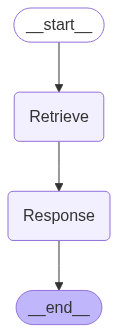

In [33]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

###**8. Invoke a Graph**

In [36]:
question = "What are the hobbies of the CEO?"
result = graph.invoke({"question": question})
print(result["response"])

The hobbies of the CEO, Amit Verma, are Golf and Reading.
